# **1.0 INTRODUCTION**
The aim of this project is to utilise ***reinforcement learning*** to train a machine to learn how to rebalance a portfolio of stocks given what happened prior in the market. For this project, our portfilio will initially focus on the ***Dow Jones Index*** of **30 constituents**.

## **1.1 Import Dependencies**

In [36]:
import yfinance as yf
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import seaborn as sns
from functools import reduce
import numpy as np

## **1.2 Data Collection & Cleaning**
We'll select the stocks from the DOW JONES for our analysis.

In [2]:
DOW_30_TICKERS = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC", 
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW"
]

We'll make dictionaries for each ticker and store financial data within them. 
<br><br>
We'll focus on ticker name, the yahoo finance object, info and historical prices over the past ***10 years***.
<br><br>
For each ticker, the financial information will be represented by a dataframe.


In [9]:
DOW_tickers_data = []
for ticker in DOW_30_TICKERS:
    ticker_dict = {
                   'ticker': ticker, 
                   'info': yf.Ticker(ticker).info,
                   'daily_prices':yf.download(ticker, period = '10y', interval = '1d')
                   }
    DOW_tickers_data.append(ticker_dict)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Here is an example of one of historical data for one of our constituents.

In [10]:
DOW_tickers_data[0]['daily_prices'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-28,58.380001,59.259998,58.380001,59.060001,51.164398,7925900
2012-03-29,58.279999,58.439999,57.240002,57.889999,50.150810,7397600
2012-03-30,58.180000,58.310001,57.540001,57.860001,50.124840,5779700
2012-04-02,57.900002,58.330002,57.470001,58.009998,50.254772,6674200
2012-04-03,57.889999,58.500000,57.750000,58.389999,50.758968,5782800


We'll now make a few changes to our dataframes.

In [11]:
# assign a column order for our dataframes
column_order = ['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume',	'tic', 'day']

for ticker in DOW_tickers_data:
    # make the index a datetime object
    ticker['daily_prices'] = ticker['daily_prices'].reset_index()
    ticker['daily_prices'] = ticker['daily_prices'].rename({'Date': 'date'}, axis = 1)
    ticker['daily_prices']['date'] = pd.to_datetime(ticker['daily_prices']['date'])
    # add a column for 'day of the week'
    ticker['daily_prices']['day'] = ticker['daily_prices']['date'].dt.dayofweek
    # add the ticker name to the dataframe
    ticker['daily_prices']['tic'] = ticker['ticker']
    # rename the adjusted closing price column
    ticker['daily_prices'] = ticker['daily_prices'].rename({'Adj Close': 'adjcp'}, axis = 1)
    # set a column order for our dataframes
    ticker['daily_prices'].columns = ticker['daily_prices'].columns.str.lower()
    ticker['daily_prices'] = ticker['daily_prices'][column_order]
    # convert date column back to str
    ticker['daily_prices']['date'] = ticker['daily_prices']['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [12]:
DOW_tickers_data[0]['daily_prices']

,date,open,high,low,close,adjcp,volume,tic,day
0,2012-03-28,58.380001,59.259998,58.380001,59.060001,51.164398,7925900,AXP,2
1,2012-03-29,58.279999,58.439999,57.240002,57.889999,50.150810,7397600,AXP,3
2,2012-03-30,58.180000,58.310001,57.540001,57.860001,50.124840,5779700,AXP,4
3,2012-04-02,57.900002,58.330002,57.470001,58.009998,50.254772,6674200,AXP,0
4,2012-04-03,57.889999,58.500000,57.750000,58.389999,50.758968,5782800,AXP,1
...,...,...,...,...,...,...,...,...,...
2512,2022-03-22,190.500000,194.350006,190.059998,191.330002,191.330002,3007000,AXP,1
2513,2022-03-23,188.830002,189.619995,185.179993,186.020004,186.020004,3664600,AXP,2
2514,2022-03-24,186.610001,189.369995,185.699997,188.889999,188.889999,2424400,AXP,3
2515,2022-03-25,190.410004,191.259995,189.000000,190.279999,190.279999,1871900,AXP,4


We'll now compile a list of the historical prices dataframes so we can create a ***panel dataset***.

In [13]:
DOW_tickers_prices = [ticker['daily_prices'] for ticker in DOW_tickers_data]

# And then compile them into a single dataframe
DOW_tickers_panel_dataset = pd.concat(DOW_tickers_prices)
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[column_order]
DOW_tickers_panel_dataset.head()

,date,open,high,low,close,adjcp,volume,tic,day
0,2012-03-28,58.380001,59.259998,58.380001,59.060001,51.164398,7925900.0,AXP,2
1,2012-03-29,58.279999,58.439999,57.240002,57.889999,50.150810,7397600.0,AXP,3
2,2012-03-30,58.180000,58.310001,57.540001,57.860001,50.124840,5779700.0,AXP,4
3,2012-04-02,57.900002,58.330002,57.470001,58.009998,50.254772,6674200.0,AXP,0
4,2012-04-03,57.889999,58.500000,57.750000,58.389999,50.758968,5782800.0,AXP,1


In [14]:
DOW_tickers_panel_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73730 entries, 0 to 761
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    73730 non-null  object 
 1   open    73729 non-null  float64
 2   high    73729 non-null  float64
 3   low     73729 non-null  float64
 4   close   73729 non-null  float64
 5   adjcp   73729 non-null  float64
 6   volume  73729 non-null  float64
 7   tic     73730 non-null  object 
 8   day     73730 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.6+ MB


We'll have a look to see if there are any na values.

In [15]:
DOW_tickers_panel_dataset[pd.isna(DOW_tickers_panel_dataset['open'])]

,date,open,high,low,close,adjcp,volume,tic,day
957,2016-01-18,NaN,NaN,NaN,NaN,NaN,NaN,CAT,0


There does seem to be a single record that consists of na values for this particular stock. <br>
<br>
We'll deal with it using ***backfill***.

In [16]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset.backfill()
DOW_tickers_panel_dataset.shape

(73730, 9)

What we need to also check is how many tickers have a full set of values we have for unique date.

In [17]:
DOW_tickers_panel_dataset.groupby('date').count().sort_values(by = 'tic')

,open,high,low,close,adjcp,volume,tic,day
date,,,,,,,,
2016-01-18,1,1,1,1,1,1,1,1
2022-03-28,3,3,3,3,3,3,3,3
2016-11-28,29,29,29,29,29,29,29,29
2016-11-25,29,29,29,29,29,29,29,29
2016-11-23,29,29,29,29,29,29,29,29
...,...,...,...,...,...,...,...,...
2020-03-25,30,30,30,30,30,30,30,30
2020-03-26,30,30,30,30,30,30,30,30
2020-03-27,30,30,30,30,30,30,30,30


Oddly, we see there are 3 tickers that have values on the ***28th of March 2022*** as well as 1 ticker on the ***18th of Jan 2016***. <br><br>
We'll need to drop these records as our algorithm won't work with this dataset.

In [18]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['date'] != '2016-01-18']
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['date'] != '2022-03-28']
DOW_tickers_panel_dataset

,date,open,high,low,close,adjcp,volume,tic,day
0,2012-03-28,58.380001,59.259998,58.380001,59.060001,51.164398,7925900.0,AXP,2
1,2012-03-29,58.279999,58.439999,57.240002,57.889999,50.150810,7397600.0,AXP,3
2,2012-03-30,58.180000,58.310001,57.540001,57.860001,50.124840,5779700.0,AXP,4
3,2012-04-02,57.900002,58.330002,57.470001,58.009998,50.254772,6674200.0,AXP,0
4,2012-04-03,57.889999,58.500000,57.750000,58.389999,50.758968,5782800.0,AXP,1
...,...,...,...,...,...,...,...,...,...
757,2022-03-21,63.119999,63.720001,62.529999,63.340000,63.340000,4836500.0,DOW,0
758,2022-03-22,64.000000,64.529999,63.240002,63.549999,63.549999,5136700.0,DOW,1
759,2022-03-23,63.400002,63.840000,63.020000,63.299999,63.299999,2936100.0,DOW,2
760,2022-03-24,63.759998,64.199997,63.410000,64.089996,64.089996,3611400.0,DOW,3


So our panel dataset has over 73,000 rows with 9 columns and one of those columns includes the ticker name.
<br><br>
We'll now export this dataframe into a csv.

In [19]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset.reset_index().drop('index', axis = 1)
DOW_tickers_panel_dataset.to_csv('data/DOW_tickers_panel_dataset.csv', index=True)

### **1.3 EDA**
With our panel dataset created, we can now perform simple EDA and data visualisations.

We can visualise the median changes in price across the years.

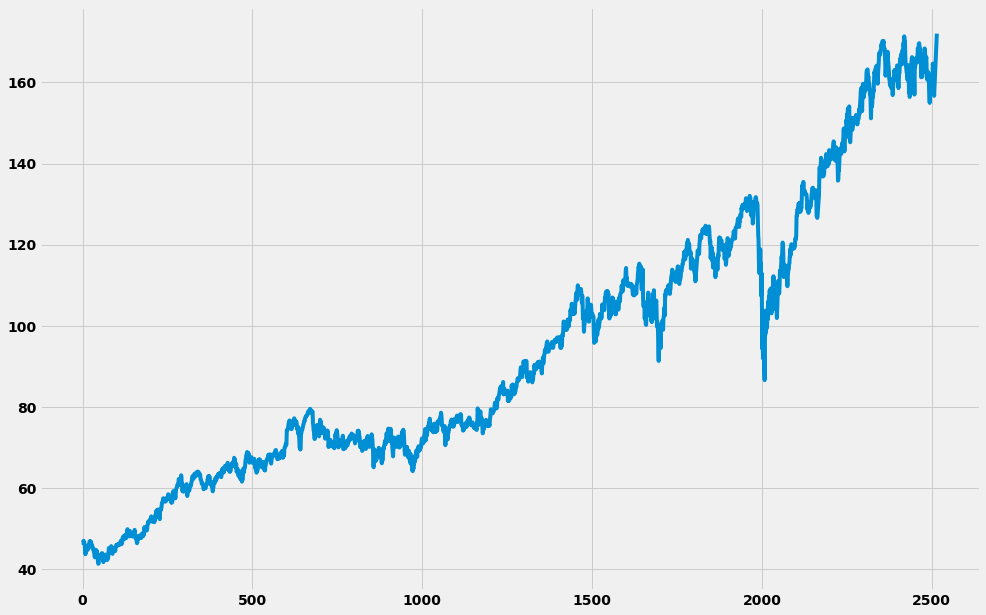

In [47]:
median_panel_dataset['adjcp'].plot(figsize = (15, 10));

In [31]:
median_panel_dataset

,date,open,high,low,close,adjcp,volume,day
0,2012-03-28,55.389999,55.959999,54.880001,55.439999,46.624031,7982700.0,2.0
1,2012-03-29,55.000000,57.993469,54.980000,57.869530,46.528835,7893200.0,3.0
2,2012-03-30,57.970001,58.310001,57.540001,57.860001,46.965179,8670300.0,4.0
3,2012-04-02,57.745590,58.330002,57.470001,58.009998,47.068317,8435800.0,0.0
4,2012-04-03,57.889999,58.460621,57.554916,57.802795,46.875866,7948100.0,1.0
...,...,...,...,...,...,...,...,...
2511,2022-03-21,163.264999,165.965004,162.864998,165.010002,165.010002,6693100.0,0.0
2512,2022-03-22,164.599998,167.339996,163.745003,166.455002,166.455002,7014300.0,1.0
2513,2022-03-23,166.995003,169.995003,166.294998,168.035004,168.035004,6274900.0,2.0
2514,2022-03-24,168.744995,170.769997,167.605003,170.185005,170.185005,4806100.0,3.0


In [27]:
median_panel_dataset = DOW_tickers_panel_dataset.groupby('date').median().reset_index()

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15, 10))
sns.lineplot(data = median_panel_dataset, 
                    x = 'date',
                    y = 'adjcp')
ax.set_ylabel('price ($)')
ax.set_xlabel('Date');

Error in callback <function flush_figures at 0x000001AB8ECF6B80> (for post_execute):


KeyboardInterrupt: 

A more important metric would be viewing average ***ROI***.
<br><br>
We'll firstly calculate it per ticker.

In [32]:
ROI_df_list = []

for ticker in DOW_30_TICKERS:
    df = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['tic'] == ticker]
    df['ROI'] = df['adjcp'].pct_change()
    df = df.dropna()
    ROI_df_list.append(df)

<ipython-input-32-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI'] = df['adjcp'].pct_change()
<ipython-input-32-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI'] = df['adjcp'].pct_change()
<ipython-input-32-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

We'll then turn list of dataframes into a single panel set and calculate the median ROI.

In [33]:
ROI_panel = pd.concat(ROI_df_list)
median_ROI_panel = ROI_panel.groupby('date').median().reset_index()

In [38]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(median_ROI_panel['date'], median_ROI_panel['ROI'])
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Date');

Error in callback <function flush_figures at 0x000001AB8ECF6B80> (for post_execute):


KeyboardInterrupt: 

The median ROI is relatively stable throughout the 10 years apart from around early 2020 due to covid and lockdown rules.
<br><br>
What we can do now is look at the top performing tickers over a range of time periods:
- ***1 month***
- ***6 month***
- ***1 year***

In [39]:
ROI_list = []

for ticker in DOW_30_TICKERS:
    df = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['tic'] == ticker]
    # we'll take the prior values for each time period
    month_1_prior = df.iloc[-22]['adjcp']
    month_6_prior = df.iloc[-(22 * 6)]['adjcp']
    year_1_prior = df.iloc[-(22 * 12)]['adjcp']
    current_value = df.iloc[-1]['adjcp']
    # now we'll calculate the ROIs
    month_1_ROI = ((100 / month_1_prior) * current_value) - 100
    month_6_ROI = ((100 / month_6_prior) * current_value) - 100
    year_1_ROI = ((100 / year_1_prior) * current_value) - 100

    summary_dict = {'ticker': ticker,
                    'month_1_ROI': month_1_ROI, 
                    'month_6_ROI': month_6_ROI,
                    'year_1_ROI': year_1_ROI}

    ROI_list.append(summary_dict)

In [40]:
ROI_df = pd.DataFrame(ROI_list)
ROI_df.head()

,ticker,month_1_ROI,month_6_ROI,year_1_ROI
0,AXP,1.024684,16.661660,30.157042
1,AMGN,8.902261,10.702629,6.612269
2,AAPL,7.361433,19.949286,44.111556
3,BA,-4.777501,-11.440759,-25.019842
4,CAT,20.937786,12.982769,3.713072


**1 month ROI**

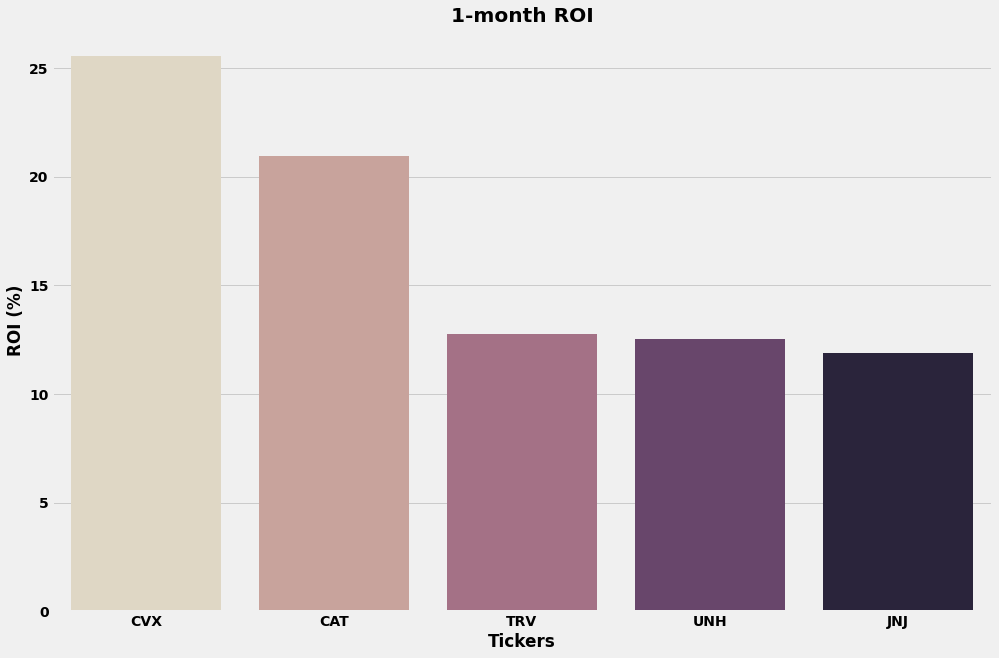

In [41]:
fig, ax = plt.subplots(figsize = (15, 10))
month_1_ROI_df = ROI_df[['ticker', 'month_1_ROI']].sort_values('month_1_ROI', ascending = False).head()
ax = sns.barplot(data = month_1_ROI_df, 
                x = 'ticker', 
                y = 'month_1_ROI',
                palette = sns.color_palette('ch:s=-.2,r=.6', n_colors=5))
ax.set_title('1-month ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

**6 month ROI**

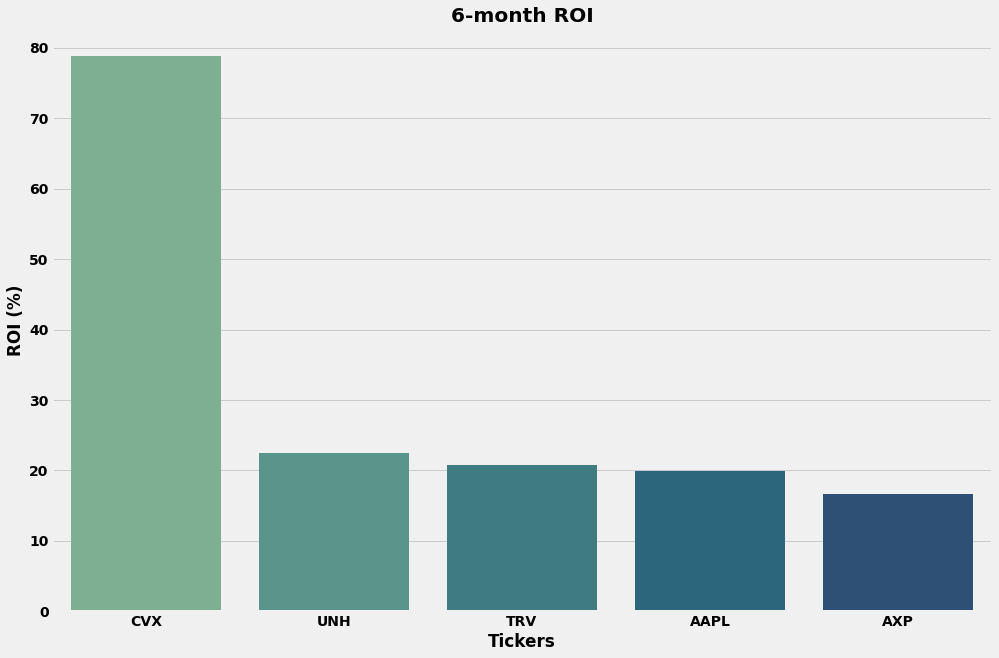

In [42]:
fig, ax = plt.subplots(figsize = (15, 10))
month_6_ROI_df = ROI_df[['ticker', 'month_6_ROI']].sort_values('month_6_ROI', ascending = False).head()
ax = sns.barplot(data = month_6_ROI_df, 
                x = 'ticker', 
                y = 'month_6_ROI',
                palette = sns.color_palette('crest', n_colors=5))
ax.set_title('6-month ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

**1 year ROI**

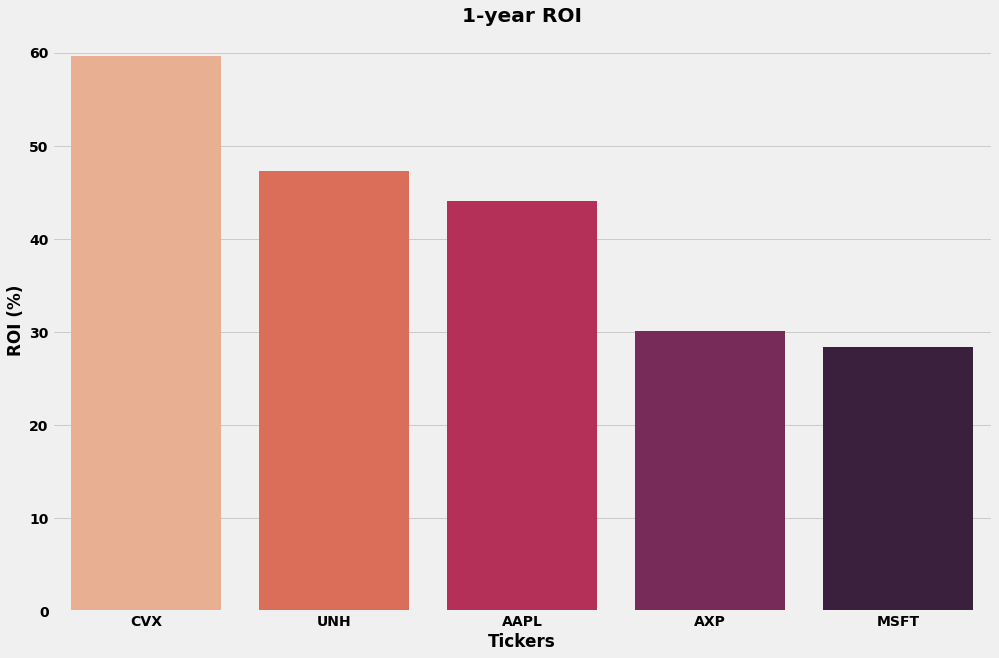

In [43]:
fig, ax = plt.subplots(figsize = (15, 10))
year_1_ROI_df = ROI_df[['ticker', 'year_1_ROI']].sort_values('year_1_ROI', ascending = False).head()
ax = sns.barplot(data = year_1_ROI_df, 
                x = 'ticker', 
                y = 'year_1_ROI', 
                palette = sns.color_palette('rocket_r', n_colors=5))
ax.set_title('1-year ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

Interestingly, we see the same ***CVX*** stock appear as the top performing stocks in each time period.

# **2.0 Data Preparation**

## **2.1 Feature Engineering**
For our feature engineering, we'll be focusing on ***technical indicators*** that focus on these categories:
<br>
- ***Trends***<br>
- ***Momentum***<br>
- ***Volume***<br>

We'll firstly import our dependencies which all come from the ***finrl*** library.

In [44]:
from finrl.apps import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


The first step is to do a general preprocessing of our data. We'll incorporate finrl's in built preprocessor for this.

In [45]:
DOW_tickers_panel_dataset_processed = FeatureEngineer(use_technical_indicator = True, use_turbulence = True).preprocess_data(DOW_tickers_panel_dataset)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is d

Successfully added technical indicators
Successfully added turbulence index


In [46]:
DOW_tickers_panel_dataset_processed.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2012-03-28,22.084999,22.194643,21.796785,22.057858,18.887579,655460400.0,AAPL,2,0.0,22.311226,21.527346,0.0,-66.666667,100.0,22.057858,22.057858,0.0
1,2012-03-28,67.550003,67.970001,67.290001,67.680000,52.711655,3431700.0,AMGN,2,0.0,22.311226,21.527346,0.0,-66.666667,100.0,67.680000,67.680000,0.0
2,2012-03-28,58.380001,59.259998,58.380001,59.060001,51.164398,7925900.0,AXP,2,0.0,22.311226,21.527346,0.0,-66.666667,100.0,59.060001,59.060001,0.0
3,2012-03-28,74.989998,75.290001,73.900002,74.330002,60.710098,3412200.0,BA,2,0.0,22.311226,21.527346,0.0,-66.666667,100.0,74.330002,74.330002,0.0
4,2012-03-28,107.959999,107.970001,103.550003,104.260002,77.188789,10244900.0,CAT,2,0.0,22.311226,21.527346,0.0,-66.666667,100.0,104.260002,104.260002,0.0


Whilst the preprocessing added a few technical indicators e.g. **SMA** and **RSI**, we'll now add a few more to our dataset.

In [48]:
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, MACD, CCIIndicator, EMAIndicator, IchimokuIndicator, AroonIndicator
from ta.momentum import RSIIndicator, stoch, WilliamsRIndicator
from ta.volume import OnBalanceVolumeIndicator, MFIIndicator

In [49]:
df_list = []
for tic in DOW_tickers_panel_dataset_processed.tic.unique():
    df = DOW_tickers_panel_dataset_processed[DOW_tickers_panel_dataset_processed['tic'] == tic]
    #Log returns
    df['log_return'] = np.log(df['adjcp'] / df['adjcp'].shift(1))
    # CCI
    _cci = CCIIndicator(high = df['high'],
                        low = df['low'], 
                        close = df['close'],
                        window = 20)
    df['20_day_CCI'] = _cci.cci()
    # Ichimoku Indicator
    ichi = IchimokuIndicator(high = df['high'],
                             low = df['low'])
                             
    df['ichimoku_span_a'] = ichi.ichimoku_a()
    df['ichimoku_span_b'] = ichi.ichimoku_b()
    df['ichimoku_span_baseline'] = ichi.ichimoku_base_line()
    df['ichimoku_span_conversion_line'] = ichi.ichimoku_conversion_line()
    # ArronIndicator
    _aroon = AroonIndicator(close = df['close'])
    df['Aroon_down'] = _aroon.aroon_down()
    df['Aroon_up'] = _aroon.aroon_up()
    df['Aroon_indicator'] = _aroon.aroon_indicator()
    #Williams R Indicator
    df['wiilliams_r'] = WilliamsRIndicator(high = df['high'],
                                            low = df['low'],
                                            close = df['close']
                                            ).williams_r()
    # On Balance Volume
    df['on_balance_volume'] = OnBalanceVolumeIndicator(close = df['close'],
                                                        volume = df['volume']
                                                        ).on_balance_volume()
    #MFI
    df['mfi'] = MFIIndicator(high = df['high'],
                            low = df['low'],
                            close = df['close'],
                            volume = df['volume']
                            ).money_flow_index()

    df_list.append(df)

We'll now concatenate the list of dataframes into a single dataframe.

In [55]:
DJIA = pd.concat(df_list)
DJIA

,date,open,high,low,close,adjcp,volume,tic,day,macd,...,ichimoku_span_a,ichimoku_span_b,ichimoku_span_baseline,ichimoku_span_conversion_line,Aroon_down,Aroon_up,Aroon_indicator,wiilliams_r,on_balance_volume,mfi
0,2012-03-28,22.084999,22.194643,21.796785,22.057858,18.887579,655460400.0,AAPL,2,0.000000,...,NaN,21.995714,NaN,NaN,NaN,NaN,NaN,NaN,655460400.0,NaN
29,2012-03-29,21.885000,22.020000,21.686787,21.780714,18.650270,608238400.0,AAPL,3,-0.006218,...,NaN,21.940715,NaN,NaN,NaN,NaN,NaN,NaN,47222000.0,NaN
58,2012-03-30,21.741785,21.805714,21.355000,21.412500,18.334978,731038000.0,AAPL,4,-0.019341,...,NaN,21.774821,NaN,NaN,NaN,NaN,NaN,NaN,-683816000.0,NaN
87,2012-04-02,21.493929,22.098928,21.442142,22.093929,18.918461,598351600.0,AAPL,0,-0.000233,...,NaN,21.774821,NaN,NaN,NaN,NaN,NaN,NaN,-85464400.0,NaN
116,2012-04-03,22.403570,22.578930,22.232500,22.475714,19.245382,834559600.0,AAPL,1,0.025347,...,NaN,21.966965,NaN,NaN,NaN,NaN,NaN,NaN,749095200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72847,2022-03-21,145.429993,147.289993,143.619995,144.229996,144.229996,7116900.0,WMT,0,1.867956,...,141.182495,139.649994,139.649994,142.714996,12.0,84.0,72.0,-25.268352,121947200.0,75.461162
72876,2022-03-22,144.610001,144.970001,142.979996,143.800003,143.800003,6745000.0,WMT,1,1.795377,...,141.399994,139.649994,139.649994,143.149994,8.0,80.0,72.0,-32.495283,115202200.0,75.939639
72905,2022-03-23,143.139999,143.729996,141.520004,141.949997,141.949997,6541800.0,WMT,2,1.570473,...,142.027496,139.649994,139.649994,144.404999,4.0,76.0,72.0,-55.051526,108660400.0,69.872940
72934,2022-03-24,142.389999,143.910004,141.880005,142.830002,142.830002,4480300.0,WMT,3,1.446569,...,142.027496,139.649994,139.649994,144.404999,20.0,72.0,52.0,-48.743109,113140700.0,67.940448


## **2.2 Forming our covariance matrix**
For our RL model to work, we are required to feed in a **covariance matrix** of stock returns for each date for each ticker. This is so we can view the correlation of prices between tickers.<br><br>
The covariance matrix will be based on values **one year** into the past.

In [57]:
DJIA = DJIA.sort_values(['date', 'tic'], ignore_index=True)
DJIA.index = DJIA.date.factorize()[0]

cov_list = []
return_list = []

lookback = 252
for i in range(lookback, len(DJIA.index.unique())):
    data_lookback = DJIA.loc[i - lookback: i, :]
    price_lookback = data_lookback.pivot_table(index = 'date', columns = 'tic', values = 'close')
    
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

DJIA_cov = pd.DataFrame({'date': DJIA.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})

For each day, we have a list that contains 29 lists. Each list is **covariance matrix** consisting of 29 values.
<br><br>
We all created a **return list** column which simply contains a dataframe of stock ROI for each ticker from a date of 1 year prior to data in the **date column** up to the date in the date column.

In [75]:
DJIA_cov

,date,cov_list,return_list
0,2013-04-02,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
1,2013-04-03,"[[0.0004235553563729969, 5.58082167914646e-05,...",tic AAPL AMGN AXP ...
2,2013-04-04,"[[0.0004228698145994918, 5.6007801731000295e-0...",tic AAPL AMGN AXP ...
3,2013-04-05,"[[0.00041887073332747823, 5.668740613110281e-0...",tic AAPL AMGN AXP ...
4,2013-04-08,"[[0.00041777605807919073, 5.729741204665731e-0...",tic AAPL AMGN AXP ...
...,...,...,...
2259,2022-03-21,"[[0.00023140096797311628, 5.559514276950343e-0...",tic AAPL AMGN AXP ...
2260,2022-03-22,"[[0.00023264162423951073, 5.504428213945517e-0...",tic AAPL AMGN AXP ...
2261,2022-03-23,"[[0.0002309944113277163, 5.4940544116675326e-0...",tic AAPL AMGN AXP ...
2262,2022-03-24,"[[0.00023274763334425535, 5.588075286986866e-0...",tic AAPL AMGN AXP ...


In [82]:
DJIA_cov['cov_list'][0]

array([[4.23912237e-04, 5.65551183e-05, 7.42872561e-05, 7.13539705e-05,
        9.03706047e-05, 9.44873264e-05, 6.61812392e-05, 6.13769697e-05,
        5.75927935e-05, 9.72135658e-05, 6.22561388e-05, 7.27431908e-05,
        7.19350334e-05, 8.66714549e-05, 1.82272039e-05, 6.33889212e-05,
        5.06224085e-05, 5.81059227e-05, 5.67995457e-05, 3.33169488e-05,
        6.21880527e-05, 5.91949775e-05, 2.87892264e-05, 2.25065508e-05,
        5.53643300e-05, 7.39992851e-05, 3.56874752e-05, 6.54543243e-05,
        3.38188741e-05],
       [5.65551183e-05, 1.43529200e-04, 5.78662359e-05, 4.90649138e-05,
        5.25690670e-05, 5.67925056e-05, 5.29015513e-05, 5.22141267e-05,
        5.15563705e-05, 6.32406705e-05, 4.36131946e-05, 5.80826373e-05,
        4.56010089e-05, 7.27329414e-05, 4.17813958e-05, 6.23688550e-05,
        4.76748802e-05, 3.84418753e-05, 4.97591825e-05, 5.55249905e-05,
        6.23912781e-05, 3.53035693e-05, 3.87321420e-05, 4.63429758e-05,
        4.30940087e-05, 5.73057245e-05,

In [81]:
DJIA_cov['return_list'][0]

tic,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2012-03-29,-0.012564,-0.005319,-0.019810,-0.003363,0.016881,0.015254,-0.002372,0.009066,-0.011492,-0.020576,...,-0.007831,-0.002175,0.005782,-0.002679,-0.002042,0.048160,-0.002933,-0.004966,-0.023597,-0.006047
2012-03-30,-0.016905,0.009655,-0.000518,0.003915,0.004716,-0.012148,0.005706,0.003369,0.017903,0.004929,...,0.010260,0.004359,0.005471,0.002985,0.009378,0.014283,-0.008403,0.004203,-0.012968,0.006248
2012-04-02,0.031824,0.002060,0.002592,0.010757,0.006853,0.017280,0.001891,0.010167,0.001371,0.004261,...,0.002865,0.000930,0.005349,0.005208,0.002196,0.003054,0.008305,0.007586,0.020006,0.002614
2012-04-03,0.017280,-0.002643,0.006551,-0.006918,-0.009697,0.007253,-0.017461,-0.010711,-0.012546,-0.017534,...,0.005453,-0.010839,0.003210,-0.006957,-0.000843,0.004736,0.011599,-0.001558,-0.009075,-0.011571
2012-04-04,-0.007961,-0.001178,-0.017469,-0.013128,0.000471,-0.016675,-0.022094,-0.014374,-0.008316,-0.022411,...,0.004649,-0.022855,0.001097,0.002534,-0.001012,-0.005724,-0.011466,-0.001820,-0.016248,-0.006430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,-0.005263,0.019110,0.016188,0.020860,0.004155,0.004804,0.000000,0.006657,0.007472,0.002943,...,0.016022,0.000000,-0.001511,0.009390,-0.000120,0.014400,0.021098,0.006509,0.029877,-0.001069
2013-03-27,-0.019647,0.015102,-0.000298,-0.004849,-0.001149,0.013192,-0.000959,-0.006530,-0.002825,0.008871,...,-0.006533,0.007457,-0.017152,-0.004393,0.000120,0.017430,0.007166,-0.010914,-0.006937,0.000134
2013-03-28,-0.020837,0.023565,0.004616,-0.004060,0.000806,0.016773,0.003361,-0.011399,0.005844,-0.004667,...,0.002268,0.008460,0.009581,0.000000,0.009836,0.010420,0.006996,0.004291,0.009314,0.000669


Now, we just merge this with our processed dataframe.

In [ ]:
DJIA = DJIA.merge(DJIA_cov, on = 'date')
DJIA = DJIA.sort_values(['date', 'tic']).reset_index(drop = True)

In [70]:
DJIA.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,...,ichimoku_span_baseline,ichimoku_span_conversion_line,Aroon_down,Aroon_up,Aroon_indicator,wiilliams_r,on_balance_volume,mfi,cov_list,return_list
0,2013-04-02,15.271429,15.647857,15.228571,15.349643,13.337509,529519200.0,AAPL,1,-0.104103,...,15.874108,16.006250,20.0,80.0,60.0,-90.065083,-1.780383e+10,55.945547,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
1,2013-04-02,102.389999,106.610001,102.389999,106.400002,84.469276,4970500.0,AMGN,1,3.665925,...,97.635002,99.744999,4.0,100.0,96.0,-1.291507,1.188640e+08,75.089297,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
2,2013-04-02,67.379997,67.760002,67.099998,67.639999,59.413723,3921600.0,AXP,1,1.279591,...,64.635000,66.505001,4.0,100.0,96.0,-4.000092,2.403280e+07,73.470619,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
3,2013-04-02,85.389999,85.500000,83.800003,84.089996,70.375557,4764900.0,BA,1,1.948002,...,80.934998,85.320000,4.0,84.0,80.0,-82.831333,5.536400e+07,64.946248,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
4,2013-04-02,86.019997,86.019997,84.470001,84.879997,64.261398,6514300.0,CAT,1,-1.751621,...,88.815002,86.225002,100.0,12.0,-88.0,-92.612678,-3.362800e+07,25.459297,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...


In [59]:
DJIA.shape

(65656, 32)

## **2.3 Building our environment**
With our data processed correctly, we now need to build the environment where our agent will operate in.
<br><br>
The environment that we are building is largely taken from the default **gym environment**, however, a few ammendments have been made so it resembles the stock market. The environment we are using is provided by **finrl**.

In [83]:
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
from gym import spaces

class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

## **2.3 Train test split**

We'll now create the train set and its **observation space**. <br><br>
As we are dealing with a panel dataset, we will split our train and test via date. We'll use **80%** for train and **20%** for test.

In [112]:
unique_dates = list(set(DJIA['date']))
unique_dates.sort()
num_unique_dates = len(unique_dates)
train_len = int(num_unique_dates * 0.8)
test_len = num_unique_dates - train_len

train_interval = unique_dates[ :train_len]
test_interval = unique_dates[train_len: ]

In [118]:
train = data_split(DJIA, train_interval[0], train_interval[-1])
train

,date,open,high,low,close,adjcp,volume,tic,day,macd,...,ichimoku_span_baseline,ichimoku_span_conversion_line,Aroon_down,Aroon_up,Aroon_indicator,wiilliams_r,on_balance_volume,mfi,cov_list,return_list
0,2013-04-02,15.271429,15.647857,15.228571,15.349643,13.337509,529519200.0,AAPL,1,-0.104103,...,15.874108,16.006250,20.0,80.0,60.0,-90.065083,-1.780383e+10,55.945547,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
0,2013-04-02,102.389999,106.610001,102.389999,106.400002,84.469276,4970500.0,AMGN,1,3.665925,...,97.635002,99.744999,4.0,100.0,96.0,-1.291507,1.188640e+08,75.089297,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
0,2013-04-02,67.379997,67.760002,67.099998,67.639999,59.413723,3921600.0,AXP,1,1.279591,...,64.635000,66.505001,4.0,100.0,96.0,-4.000092,2.403280e+07,73.470619,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
0,2013-04-02,85.389999,85.500000,83.800003,84.089996,70.375557,4764900.0,BA,1,1.948002,...,80.934998,85.320000,4.0,84.0,80.0,-82.831333,5.536400e+07,64.946248,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
0,2013-04-02,86.019997,86.019997,84.470001,84.879997,64.261398,6514300.0,CAT,1,-1.751621,...,88.815002,86.225002,100.0,12.0,-88.0,-92.612678,-3.362800e+07,25.459297,"[[0.0004239122368406726, 5.6555118275328465e-0...",tic AAPL AMGN AXP ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,2020-06-08,308.640015,315.839996,307.929993,309.480011,301.548218,4635500.0,UNH,0,7.092211,...,295.699997,303.319992,32.0,96.0,64.0,-20.483053,5.061255e+08,60.299862,"[[0.00062949795800386, 0.00039722417018160086,...",tic AAPL AMGN AXP ...
1809,2020-06-08,199.580002,199.960007,197.130005,199.600006,197.462692,7628100.0,V,0,5.623610,...,185.840004,194.240005,4.0,96.0,92.0,-3.146858,1.531094e+09,67.425438,"[[0.00062949795800386, 0.00039722417018160086,...",tic AAPL AMGN AXP ...
1809,2020-06-08,57.650002,58.200001,57.270000,58.090000,53.729275,14963000.0,VZ,0,0.375115,...,55.934999,56.315001,56.0,100.0,44.0,-2.428268,5.931377e+08,57.866625,"[[0.00062949795800386, 0.00039722417018160086,...",tic AAPL AMGN AXP ...
1809,2020-06-08,45.490002,47.380001,45.490002,47.020000,45.117329,7233600.0,WBA,0,0.773289,...,42.015001,44.305000,32.0,100.0,68.0,-4.477619,4.062258e+08,72.285860,"[[0.00062949795800386, 0.00039722417018160086,...",tic AAPL AMGN AXP ...


In [119]:
# observation space
stock_dimension = len(train['tic'].unique())
state_space = stock_dimension
print(f'Stock Dimension: {stock_dimension}, State_space: {state_space}')

Stock Dimension: 29, State_space: 29


In [120]:
technical_indicators_list = list(DJIA.columns[9:-2])

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": technical_indicators_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

We now create our training environment using the training set and the pre build custom environment.

In [121]:
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# **3.0 Modelling**
With everthing setup, we can now begin modelling. <br><br>
The first step is to create our **agent** who will act in our **environment**.

In [122]:
agent = DRLAgent(env=env_train)

We'll also make some **directories** to store our logs.

In [126]:
import os
from finrl.apps import config
from finrl.apps import config_tickers

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

## **3.1 Baseline Model**
For our baseline model, we'll be making use of an untuned **A2C algorithm**.

In [123]:
A2C_PARAMS = {'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
model_a2c = agent.get_model(model_name = 'a2c', model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


-------------------------------------
| time/                 |           |
|    fps                | 64        |
|    iterations         | 100       |
|    time_elapsed       | 7         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | -3.58e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.51e+08  |
|    reward             | 1356692.9 |
|    std                | 0.999     |
|    value_loss         | 2.02e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 85        |
|    iterations         | 200       |
|    time_elapsed       | 11        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

FileNotFoundError: [Errno 2] No such file or directory: 'results/cumulative_reward.png'

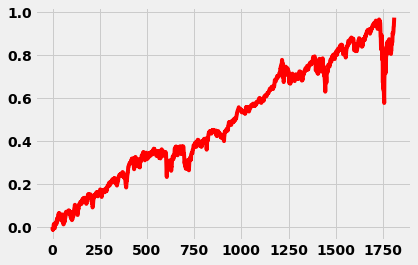

In [124]:
trained_a2c = agent.train_model(model = model_a2c,
                                tb_log_name = 'a2c',
                                total_timesteps = 50000)

In [ ]:
import os
os.makedirs('config/D')

In [129]:
config.DATA_SAVE_DIR

'datasets'